In [1]:
import os
import sys

# os.chdir('../')
sys.path.append(os.getcwd())

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from sklearn.decomposition import PCA
from scipy.stats import fisher_exact, chi2_contingency
from sklearn.manifold import TSNE, MDS
from tqdm import tqdm
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import MinMaxScaler
from multipy.fwer import sidak, hochberg
import random

import importlib
imported_module = importlib.import_module("utils.data_utils")
importlib.reload(imported_module)

from utils.viz_utils import plot_usage_matrix_pca, plot_boxplots_for_usage_matrix, _plot_feature_importance, plot_v_usage_hist, \
                                plot_cluster_map, significant_clones_distribution, plot_results_for_hla_class, plot_generated_to_real_distribution, \
                            plot_olga_cleanup_data, plot_clusters_of_clonotypes, plot_cooccurence_heatmap_with_epitopes_labeling, \
                            plot_clonotype_clustering_with_epitope_labeling, plot_cooccurence_heatmap_with_epitopes_labeling_bubble, \
                            plot_volcano
from utils.ml_utils import get_parameters, prepare_data, evaluate_models, split_data_by_batch, cross_validation_between_batches, make_hla_predictor
from utils.data_utils import prepare_run_column, prepare_clonotype_matrix
from utils.stats_utils import evaluate_anova_testing, evaluate_mannwhitneyu_testing, get_top_changed_clonotypes
from utils.clustering_utils import seqs2hamming, check_significant_epitopes_for_cluster, get_most_frequent_cluster_by_vdjdb_occurence, \
                                    create_summary_stats_table
from utils.weblogo_utils import create_web_logo
from math import sqrt


import warnings
warnings.filterwarnings('ignore')

In [2]:
vdjdb = pd.read_csv('data/vdjdb.txt', sep='\t')

In [3]:
um = pd.read_csv('data/standardized_usage_matrix_fmba_TRB.csv').drop(columns=['Unnamed: 0'])

In [4]:
train_runs = prepare_run_column(um[~um.is_test_run]).run
test_runs = prepare_run_column(um[um.is_test_run]).run

In [5]:
desc = pd.read_csv('data/desc_fmba_not_nan_hla.csv').drop(columns=['Unnamed: 0']).merge(um[['run', 'is_test_run']])
desc['covid'] = desc.COVID_status.apply(lambda x: 'covid' if x == 'COVID' else 'healthy')
desc

,run,reads,clonotypes,singletons,doubletons,file.id,sequencingDate,folder,R1,R2,...,HLA-DRB1.2,id,subsequent_sequencing,HLA-DRB4.1,HLA-DRB3.1,HLA-DRB5.1,gene,is.bad.reseq,is_test_run,covid
0,020000010808_S3_L001.clonotypes.TRB.txt,623811,4324,491,263,020000010808_S3_L001,2020 10 19,2020/10_FMBA_NovaSeq5,020000010808_S3_L001_R1_001.fastq.gz,020000010808_S3_L001_R2_001.fastq.gz,...,DRB1*16:01,20000010,NaN,NaN,NaN,NaN,TRB,NaN,False,covid
1,020000110808_S14_L001.clonotypes.TRB.txt,13119545,13264,573,219,020000110808_S14_L001,2020 09 05,2020/09_FMBA_NovaSeq_DNA,020000110808_S14_L001_R1_001.fastq.gz,020000110808_S14_L001_R2_001.fastq.gz,...,DRB1*15:01,20000110,NaN,NaN,NaN,NaN,TRB,NaN,False,covid
2,020000190808_S27_L001.clonotypes.TRB.txt,6942203,16977,1198,550,020000190808_S27_L001,2020 10 19,2020/10_FMBA_NovaSeq5,020000190808_S27_L001_R1_001.fastq.gz,020000190808_S27_L001_R2_001.fastq.gz,...,DRB1*15:02,20000190,NaN,NaN,NaN,NaN,TRB,NaN,False,covid
3,020000200808_S181_L002.clonotypes.TRB.txt,6583555,14220,916,420,020000200808_S181_L002,2020 10 19,2020/10_FMBA_NovaSeq5,020000200808_S181_L002_R1_001.fastq.gz,020000200808_S181_L002_R2_001.fastq.gz,...,DRB1*04:04,20000200,NaN,NaN,NaN,NaN,TRB,NaN,False,healthy
4,020000280808_S59_L001.clonotypes.TRB.txt,2005779,6144,477,260,020000280808_S59_L001,2020 10 19,2020/10_FMBA_NovaSeq5,020000280808_S59_L001_R1_001.fastq.gz,020000280808_S59_L001_R2_001.fastq.gz,...,DRB1*13:03,20000280,NaN,NaN,NaN,NaN,TRB,NaN,False,covid
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
951,780008510808_S152_L002.clonotypes.TRB.txt,125864,7215,1173,793,780008510808_S152_L002,2020 09 27,2020/09_FMBA_NovaSeq3_DNA,780008510808_S152_L002_R1_001.fastq.gz,780008510808_S152_L002_R2_001.fastq.gz,...,DRB1*15:01,780008510,NaN,NaN,NaN,NaN,TRB,NaN,False,covid
952,780008550808_S150_L002.clonotypes.TRB.txt,3070841,8864,398,150,780008550808_S150_L002,2020 09 27,2020/09_FMBA_NovaSeq3_DNA,780008550808_S150_L002_R1_001.fastq.gz,780008550808_S150_L002_R2_001.fastq.gz,...,DRB1*15:01,780008550,NaN,NaN,NaN,NaN,TRB,NaN,False,covid
953,910000140808_S123_L002.clonotypes.TRB.txt,3095012,27443,1318,643,910000140808_S123_L002,2020 09 28,2020/09_FMBA_NovaSeq2_DNA,910000140808_S123_L002_R1_001.fastq.gz,910000140808_S123_L002_R2_001.fastq.gz,...,DRB1*07:01,910000140,NaN,NaN,NaN,NaN,TRB,NaN,False,covid
954,910000320808_S121_L002.clonotypes.TRB.txt,203560,11451,2013,1299,910000320808_S121_L002,2020 09 28,2020/09_FMBA_NovaSeq2_DNA,910000320808_S121_L002_R1_001.fastq.gz,910000320808_S121_L002_R2_001.fastq.gz,...,DRB1*07:01,910000320,NaN,NaN,NaN,NaN,TRB,NaN,False,covid


In [6]:
desc.COVID_status.value_counts()

COVID      661
healthy    295
Name: COVID_status, dtype: int64

# β chain biomarkers postprocessing

In [7]:
os.getcwd()

'/home/evlasova/tcr-covid-classifier'

In [8]:
raw_beta_cm = pd.read_csv('data/significant_clone_matrix_fisher_fmba_TRB_top_500k.csv').drop(columns=['Unnamed: 0'])

In [9]:
raw_beta_cm

,CANSLGGSYEQYF,CASARGYEQYF,CASGLGGNQPQHF,CASGLGGSYEQYF,CASGLSGGNQPQHF,CASGPPYEQYF,CASMRGYEQYF,CASNLGGSYEQYF,CASRDAYEQYF,CASRGGPYEQYF,...,CSARSSYEQYF,CSARTSYEQYF,CSASDRGYEQYF,CSASDSYEQYF,CSASGGGYEQYF,CSASSGHEQYF,CSATDLNTEAFF,CSATSGHEQYF,GASSLSGGNQPQHF,run
0,0,0,0,0,3,1,0,0,0,0,...,0,0,0,0,0,0,0,0,2,020000010808_S3_L001.clonotypes.TRB.txt
1,4,0,0,3,0,0,0,3,0,0,...,0,0,0,3,0,0,0,0,0,020000420808_S51_L001.clonotypes.TRB.txt
2,0,0,1,0,0,0,0,0,0,1,...,1,0,0,0,0,0,0,0,0,020003810808_S104_L002.clonotypes.TRB.txt
3,1,0,0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,050000200808_S157_L002.clonotypes.TRB.txt
4,0,0,2,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,270000010808_S182_L002.clonotypes.TRB.txt
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
951,1,1,2,1,0,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,640002910808_S86_L001.clonotypes.TRB.txt
952,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,550003260808_S186_L002.clonotypes.TRB.txt
953,0,1,1,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,640003580808_S34_L001.clonotypes.TRB.txt
954,0,0,0,1,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,640002220808_S31_L001.clonotypes.TRB.txt


In [10]:
clean_beta_cm = pd.read_csv('data/significant_clone_matrix_fisher_fmba_TRB_top_500k_wo_leaks.csv').drop(columns=['Unnamed: 0'])

In [11]:
clean_beta_cm

,run,CANSLGGSYEQYF,CASARGYEQYF,CASGLGGNQPQHF,CASGLGGSYEQYF,CASGLSGGNQPQHF,CASGPPYEQYF,CASMRGYEQYF,CASNLGGSYEQYF,CASRDAYEQYF,...,CSARKSYEQYF,CSARSGHEQYF,CSARSSYEQYF,CSARTSYEQYF,CSASDRGYEQYF,CSASDSYEQYF,CSASGGGYEQYF,CSASSGHEQYF,CSATDLNTEAFF,CSATSGHEQYF
0,020000010808_S3_L001,0,0,0,0,3,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,020000420808_S51_L001,4,0,0,3,0,0,0,3,0,...,0,0,0,0,0,3,0,0,0,0
2,020003810808_S104_L002,0,0,1,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
3,050000200808_S157_L002,1,0,0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,270000010808_S182_L002,0,0,2,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
951,640002910808_S86_L001,1,1,2,1,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
952,550003260808_S186_L002,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
953,640003580808_S34_L001,0,1,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
954,640002220808_S31_L001,0,0,0,1,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0


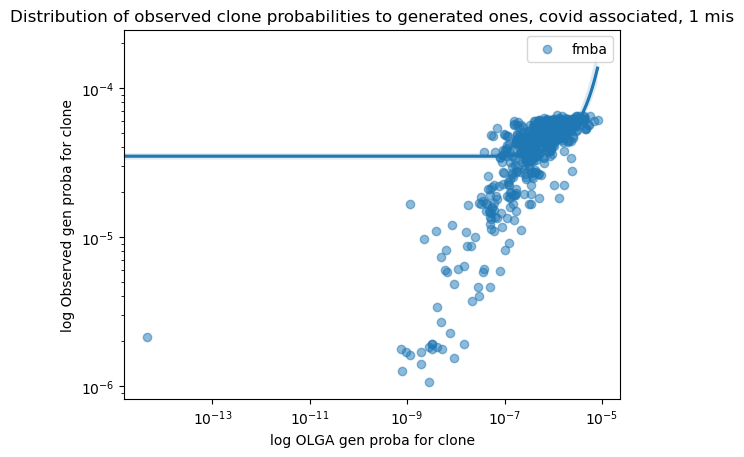

In [12]:
probas_beta = plot_generated_to_real_distribution(pgen_paths=['data/covid_fmba_TRB_pgen.csv'], 
                                    cm_paths=['data/significant_clone_matrix_fisher_fmba_TRB_top_500k.csv'], 
                                    desc='covid associated, 1 mis', 
                                    run_to_number_of_clones_path='data/run_to_number_of_clones_fmba_TRB.csv', 
                                    labels=['fmba'])['fmba']

In [13]:
covid_clones_beta = clean_beta_cm.columns[1:]
res_beta = seqs2hamming(covid_clones_beta, viz_method='graphopt')

In [14]:
res_beta

,cdr3,cluster,x,y,cluster_size,x_mean,y_mean
0,CANSLGGSYEQYF,0,-219.057682,-93.497652,169,-212.149879,17.866467
1,CASSLGGSYEQYF,0,-221.977838,-8.104051,169,-212.149879,17.866467
2,CASGLGGSYEQYF,0,-256.246793,-93.224565,169,-212.149879,17.866467
3,CASNLGGSYEQYF,0,-240.870220,-85.582866,169,-212.149879,17.866467
4,CASRPGGSYEQYF,0,-277.373371,113.222404,169,-212.149879,17.866467
...,...,...,...,...,...,...,...
510,CSARTSYEQYF,54,-440.844199,-345.279246,5,-451.531232,-353.469689
511,CSASDRGYEQYF,55,283.298053,480.291945,1,283.298053,480.291945
512,CSASDSYEQYF,56,-381.599304,470.547060,1,-381.599304,470.547060
513,CSASGGGYEQYF,57,-486.675853,400.912197,1,-486.675853,400.912197


In [15]:
beta_cluster_to_epi = {}
for cluster_index in range(res_beta.cluster.max()+1):
    beta_cluster_to_epi[cluster_index] = check_significant_epitopes_for_cluster(vdjdb, res_beta, cluster_index, dist=1, gene='TRB', alpha=0.05)

# α chain biomarkers postprocessing

In [16]:
clean_alpha_cm = pd.read_csv('data/significant_clone_matrix_fisher_fmba_TRA_top_500k_wo_leaks.csv').drop(columns=['Unnamed: 0'])

In [17]:
raw_alpha_cm = pd.read_csv('data/significant_clone_matrix_fisher_fmba_TRA_top_500k.csv').drop(columns=['Unnamed: 0'])

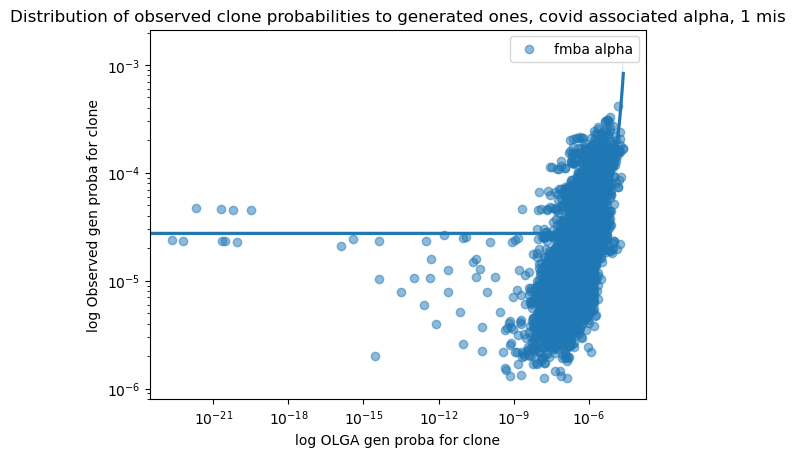

In [18]:
probas_alpha = plot_generated_to_real_distribution(pgen_paths=['data/covid_fmba_TRA_pgen.csv'], 
                                    cm_paths=['data/significant_clone_matrix_fisher_fmba_TRA_top_500k.csv'], 
                                    desc='covid associated alpha, 1 mis', 
                                    run_to_number_of_clones_path='data/run_to_number_of_clones_fmba_TRA.csv', 
                                    labels=['fmba alpha'],
                                    make_bool_features=False)['fmba alpha']

In [19]:
covid_clones_alpha = clean_alpha_cm.columns[1:]
res_alpha = seqs2hamming(covid_clones_alpha, viz_method='drl')

In [20]:
res_alpha

,cdr3,cluster,x,y,cluster_size,x_mean,y_mean
0,CAAADNFNKFYF,0,92.196564,96.512482,792,61.591043,50.408041
1,CAAANNFNKFYF,0,91.020935,96.586479,792,61.591043,50.408041
2,CAAAYNFNKFYF,0,39.903095,139.427582,792,61.591043,50.408041
3,CAAEDNFNKFYF,0,92.583504,96.712906,792,61.591043,50.408041
4,CAAGDNFNKFYF,0,42.054192,7.176530,792,61.591043,50.408041
...,...,...,...,...,...,...,...
4074,CVVRYDSWGKLQF,132,308.156830,118.758141,9,308.135810,118.633692
4075,CVVSDLMEYGNKLVF,133,-329.952606,241.792587,1,-329.952606,241.792587
4076,CVVSELSGGYQKVTF,134,317.266144,162.791885,2,317.141983,163.025986
4077,CVVSEPSGGYQKVTF,134,317.017822,163.260086,2,317.141983,163.025986


In [21]:
alpha_cluster_to_epi = {}
for cluster_index in range(res_alpha.cluster.max()+1):
    alpha_cluster_to_epi[cluster_index] = check_significant_epitopes_for_cluster(vdjdb, res_alpha, cluster_index, dist=1, gene='TRA')

In [22]:
alpha_cluster_to_epi[0]

,antigen.epitope,antigen.species,count
7,GLMWLSYFI,SARS-CoV-2,4
4,FTSDYYQLY,SARS-CoV-2,16
11,MFLARGIVF,SARS-CoV-2,27
13,NQKLIANQF,SARS-CoV-2,31
18,SGPLKAEIAQRLED,InfluenzaA,33
20,VPYFNMVYM,SARS-CoV-2,50


# α, β co-occorence analysis

In [23]:
cooccurence_dist1_epitopes = [[set() for _ in range(res_alpha.cluster.max() + 1)] for _ in
                                  range(res_beta.cluster.max() + 1)]
for beta_cluster in res_beta.cluster.unique():
    for alpha_cluster in res_alpha.cluster.unique():
        alpha_epi = set(alpha_cluster_to_epi[alpha_cluster]['antigen.epitope']) if alpha_cluster_to_epi[alpha_cluster] is not None else set()
        beta_epi = set(beta_cluster_to_epi[beta_cluster]['antigen.epitope']) if beta_cluster_to_epi[beta_cluster] is not None else set()
        cooccurence_dist1_epitopes[beta_cluster][alpha_cluster] = alpha_epi.intersection(beta_epi)

In [24]:
cooccurence_df = pd.read_csv('data/TRA_TRB_cooccurence_matrix_cooccurence_85.csv').T
annot_df = pd.read_csv('data/alpha_beta_paired_epitopes.csv').T

In [25]:
all_alpha_cm = pd.read_csv('data/clone_matrix_fmba_TRA_top_500k.csv', nrows=50000)
all_alpha_cm = prepare_clonotype_matrix(clonotype_matrix=all_alpha_cm).merge(clean_alpha_cm)
fold_change_data_alpha = get_top_changed_clonotypes(clonotype_matrix=all_alpha_cm.merge(prepare_run_column(desc[~desc.folder.str.contains('NovaSeq7')][['run']])), 
                           desc=desc, 
                           pvals=pd.read_csv('data/covid_significant_clone_pvals_fmba_TRA_top_500k.csv').drop(columns=['Unnamed: 0']), 
                           log_fold_change_threshold=2, 
                           logp_threshold=1,
                           healthy_col='COVID_status', 
                           healthy_label='healthy')
fold_change_data_alpha

v


,clone,pval,count_of_ways_h,count_of_ways_i,fold_change,log_fold_change
0,AAAGNKLTF,9.364717e-01,63,115,1.825397,0.868210
1,AAGGTSYGKLTF,8.979570e-01,431,919,2.132251,1.092377
2,AAGNKLTF,5.093598e-01,15,36,2.400000,1.263034
3,AAGNMLTF,9.594918e-01,79,143,1.810127,0.856091
4,AAGNNRKLIW,3.004676e-01,28,74,2.642857,1.402098
...,...,...,...,...,...,...
53904,CVVVYNFNKFYF,8.501016e-09,45,241,5.355556,2.421036
53905,CVVYLYNFNKFYF,6.723010e-06,35,172,4.914286,2.296982
53906,CVVYNFNKFYF,2.873274e-16,101,522,5.168317,2.369695
53907,CVYNFNKFYF,8.358170e-09,33,199,6.030303,2.592231


In [26]:
all_beta_cm = pd.read_csv('data/clone_matrix_fmba_TRB_top_500k.csv', nrows=50000)
all_beta_cm = prepare_clonotype_matrix(clonotype_matrix=all_beta_cm).merge(clean_beta_cm)
fold_change_data_beta = get_top_changed_clonotypes(clonotype_matrix=all_beta_cm.merge(prepare_run_column(desc[~desc.folder.str.contains('NovaSeq7')][['run']])), 
                           desc=desc, 
                           pvals=pd.read_csv('data/covid_significant_clone_pvals_fmba_TRB_top_500k.csv').drop(columns=['Unnamed: 0']), 
                           log_fold_change_threshold=2, 
                           logp_threshold=1,
                           healthy_col='COVID_status', 
                           healthy_label='healthy')
fold_change_data_beta

v


,clone,pval,count_of_ways_h,count_of_ways_i,fold_change,log_fold_change
0,CAAADGTVNSPLHF,4.457653e-01,0,1,inf,inf
1,CAAADYGYTF,4.831317e-01,6,14,2.333333,1.222392
2,CAAAGANVLTF,3.657760e-02,3,22,7.333333,2.874469
3,CAAAGDGNTIYF,4.628622e-01,1,4,4.000000,2.000000
4,CAAAGGDTQYF,8.242545e-01,5,7,1.400000,0.485427
...,...,...,...,...,...,...
50502,CSASDSYEQYF,1.384308e-06,44,190,4.318182,2.110424
50503,CSASGGGYEQYF,4.783870e-07,32,143,4.468750,2.159871
50504,CSASSGHEQYF,5.349557e-07,12,88,7.333333,2.874469
50505,CSATDLNTEAFF,5.879045e-07,11,85,7.727273,2.949959


# plotting fig2

In [27]:
from source.alpha_beta_paired_clones_search import plot_cooccured_epitopes_table

/home/evlasova/tcr-covid-classifier


In [28]:
desc = prepare_run_column(desc)

(array([2836., 2660., 1183.,  472.,  290.,  190.,   99.,   82.,   61.,
         151.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

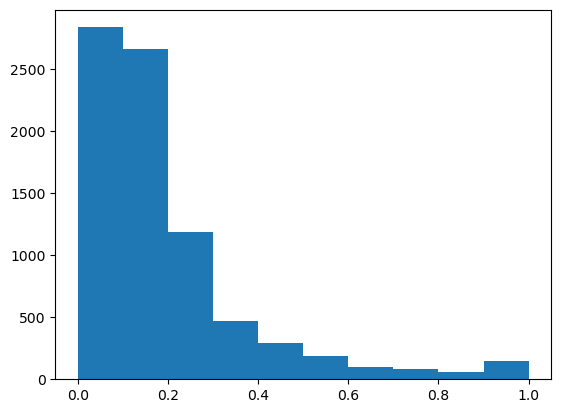

In [29]:
plt.hist(cooccurence_df.to_numpy().flatten())

updated version
0.027123580229151133 234.61831824364413 0.6679853780480164 2.2217944013809592e-09 0.0038689210349113555
0.05906392841707177 56.693068283682464 0.6636145408619681 6.101417448574338e-08 0.009323228074121549
FLGIITTVA
updated version
0.0662117630013858 254.0429315081244 0.7592238747948867 5.542403442438933e-13 0.007267208884145666
0.11201997035964606 -281.55643963703915 0.9156797576383586 7.820126396567969e-22 0.006884844407189299
NCTFEYVSQPFLMDL
KLNIKLLGV
FLNRFTTTL
36


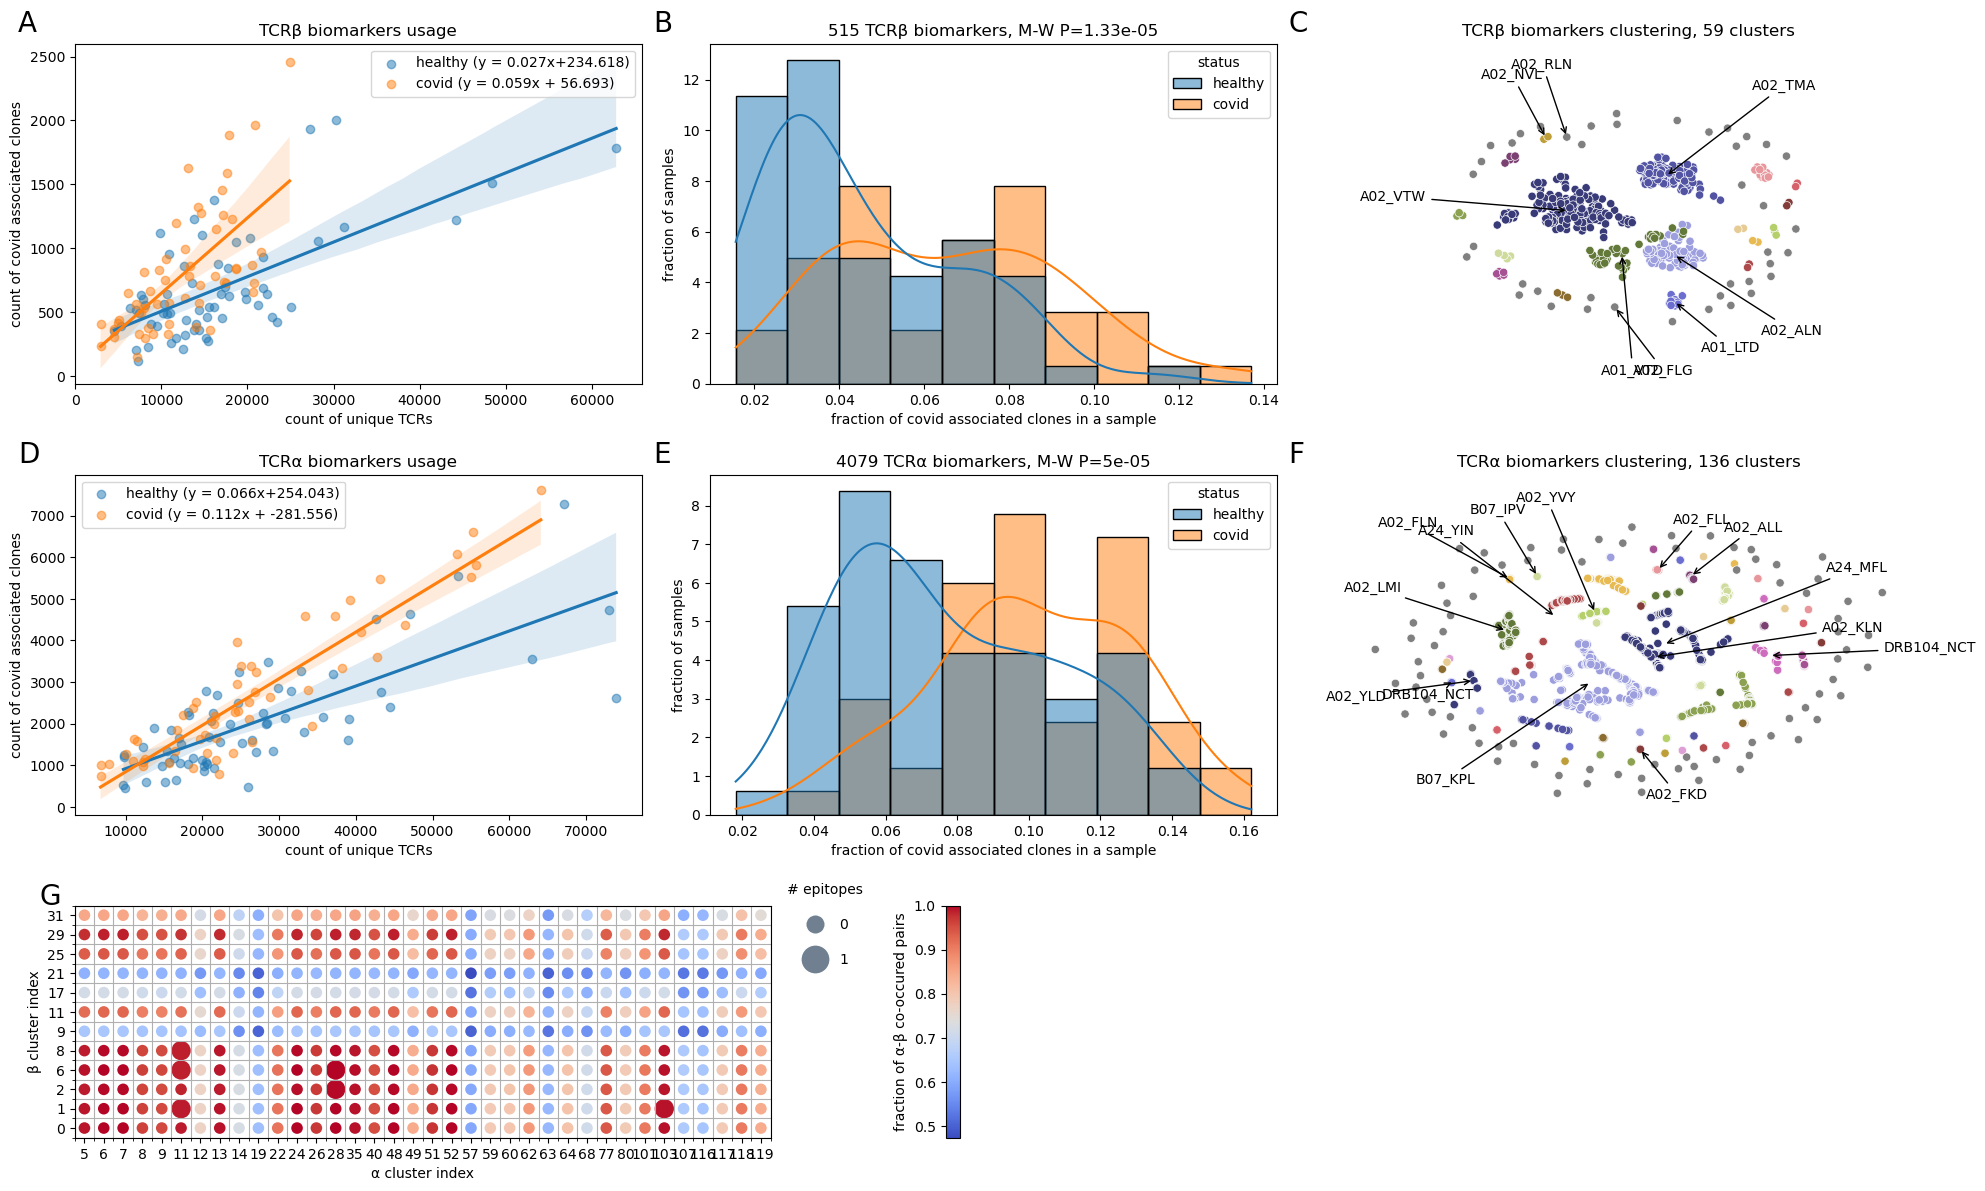

In [30]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import numpy as np
time = np.linspace(0, 10, 1000)
height = np.sin(time)
weight = time*0.3 + 2
score = time**2 + height
distribution = np.random.normal(0, 1, len(time))
fig = plt.figure(figsize=(20, 12))
gs = GridSpec(nrows=11, 
              ncols=6)
font_size=20
delta_x=-0.1
delta_y=1.1

ax0 = fig.add_subplot(gs[:4, :2])
ax1 = fig.add_subplot(gs[:4, 2:4])
ax5 = fig.add_subplot(gs[:4, 4:])
significant_clones_distribution(significant_clonotype_matrix=prepare_run_column(clean_beta_cm[clean_beta_cm.run.isin(test_runs)]), 
                                run_to_number_of_clones=pd.read_csv('data/run_to_number_of_clones_fmba_TRB.csv'), 
                                desc=desc, 
                                data_description='TCRβ biomarkers',
                                by='covid',
                                reg_ax=ax0, 
                                hist_ax=ax1)
ax0.set_title('TCRβ biomarkers usage')
ax0.legend()
ax0.text(delta_x, delta_y, 'A',
     horizontalalignment='left',
     verticalalignment='top',
    transform=ax0.transAxes,
        size=font_size)

ax1.text(delta_x, delta_y, 'B',
     horizontalalignment='left',
     verticalalignment='top',
    transform=ax1.transAxes,
        size=font_size)

plot_clonotype_clustering_with_epitope_labeling(res_beta, beta_cluster_to_epi, vdjdb, gene='TRB', dist_to_center=850, global_zero_based=True, ax=ax5)
ax5.set_xlim(-1000, 1000)
ax5.set_ylim(-1000, 1000)
ax5.text(delta_x, delta_y, 'C',
     horizontalalignment='left',
     verticalalignment='top',
    transform=ax5.transAxes,
        size=font_size)
ax5.axis('off')
ax5.legend().remove()
ax5.set_title(f'TCRβ biomarkers clustering, {res_beta.cluster.max() + 1} clusters')

####################################################

ax2 = fig.add_subplot(gs[4:8, :2])
ax3 = fig.add_subplot(gs[4:8, 2:4])
ax6 = fig.add_subplot(gs[4:8, 4:])
significant_clones_distribution(significant_clonotype_matrix=prepare_run_column(clean_alpha_cm[clean_alpha_cm.run.isin(test_runs)]), 
                                run_to_number_of_clones=pd.read_csv('data/run_to_number_of_clones_fmba_TRA.csv'), 
                                desc=desc, 
                                data_description='TCRα biomarkers',
                                by='covid',
                                reg_ax=ax2, 
                                hist_ax=ax3)
ax2.set_title(f'TCRα biomarkers usage')
ax2.legend()
ax2.text(delta_x, delta_y, 'D',
     horizontalalignment='left',
     verticalalignment='top',
    transform=ax2.transAxes,
        size=font_size)

ax3.text(delta_x, delta_y, 'E',
     horizontalalignment='left',
     verticalalignment='top',
    transform=ax3.transAxes,
        size=font_size)

plot_clonotype_clustering_with_epitope_labeling(res_alpha, 
                                                alpha_cluster_to_epi, 
                                                vdjdb, 
                                                gene='TRA', 
                                                cluster_size_threshold=0, 
                                                dist_to_center=450, 
                                                center_diff_threshold=75,
                                                ax=ax6)
ax6.text(delta_x, delta_y, 'F',
     horizontalalignment='left',
     verticalalignment='top',
    transform=ax6.transAxes,
        size=font_size)
ax6.axis('off')
ax6.set_xlim(-500, 500)
ax6.set_ylim(-500, 600)
ax6.legend().remove()
ax6.set_title(f'TCRα biomarkers clustering, {res_alpha.cluster.max() + 1} clusters')
###################################################

ax7 = fig.add_subplot(gs[8:, :3])
plot_cooccurence_heatmap_with_epitopes_labeling_bubble(cooccurence_df, annot_df, fig=fig, ax=ax7, 
                                                       corr_threshold_row=np.quantile(cooccurence_df.to_numpy().flatten(), 0.95), 
                                                       corr_threshold_col=np.quantile(cooccurence_df.to_numpy().flatten(), 0.95), 
       epitopes_count_threshold=0,  legend_x=1.15)
ax7.text(delta_x+0.05, delta_y, 'G',
     horizontalalignment='left',
     verticalalignment='top',
    transform=ax7.transAxes,
        size=font_size)

###################################################

# ax8 = fig.add_subplot(gs[8:, 3:])
# plot_cooccured_epitopes_table(res_alpha, res_beta, cooccurence_dist1_epitopes, vdjdb, ax=ax8)
# ax8.text(delta_x+0.05, delta_y, 'H',
#      horizontalalignment='left',
#      verticalalignment='top',
#     transform=ax7.transAxes,
#         size=font_size)
# ax8.axis('off')
# ax8.axis('tight')

###################################################
plt.tight_layout()
plt.savefig("figures/fig2.svg")
plt.savefig("figures/fig2.pdf")
plt.savefig("figures/fig2.png")
plt.show()

Figure 2. FMBA data TCRα and TCRβ biomarkers analysis.

A, D. Scatterplots comparing the distribution of the number of COVID-associated TCRβs/TCRαs to the total number of unique TCRβs/TCRαs sampled for COVID-19 patients and healthy donors.

B, E. Distribution of the number of COVID-associated TCRβs/TCRαs showing the significant difference in COVID-19 patients/ healthy donors.

C, F. Vizualization of COVID-associated TCRβs/TCRαs based on hamming distance. The closer the points are the less the hamming distance between the CDRs is.

G. Coouccurence of CDRs in α/β clusters. Coouccurence was calculated as the percent of TCRα/TCRβ pairs which are found together in more than 80% of samples which contain either the described TCRα, or TCRβ biomarker. The number in each cell of the matrix corresponds to the number of epitopes from VDJdb, which are found to be associated with both TCRα and TCRβ clusters.

# plotting supp fig 1

In [31]:
df = fold_change_data_alpha[(fold_change_data_alpha['log_fold_change'] != np.inf) & (fold_change_data_alpha['log_fold_change'] > 1)]
df['logp'] = np.log10(df.pval)

[[2.64981365e+00 2.53973325e+00 1.84130225e+00 ... 2.36969451e+00
  2.59223050e+00 1.80589248e+00]
 [1.41841357e-08 6.24076992e-07 1.27621539e-05 ... 2.87327443e-16
  8.35816960e-09 2.90427194e-06]]


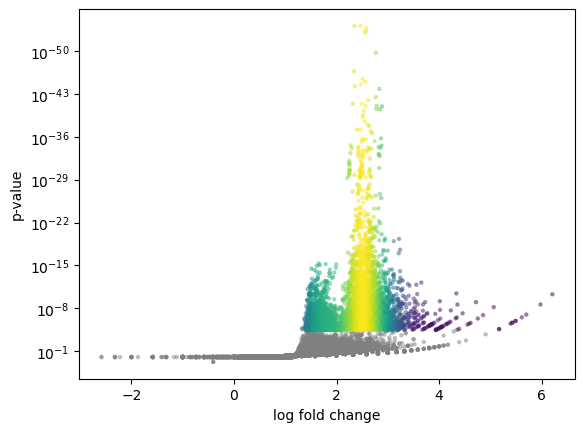

In [32]:
plot_volcano(fold_change_data_alpha, selected_clones=clean_alpha_cm.columns)

In [35]:
raw_beta_cm = prepare_run_column(raw_beta_cm)
raw_alpha_cm = prepare_run_column(raw_alpha_cm)

updated version
0.02888788320836216 238.8858196609383 0.6769914279431406 1.8556586760265e-32 0.002070813927315125
0.034976670464875 311.55289891063893 0.643375018257274 2.4515069620118704e-72 0.0016906440532641895
updated version
0.07949260762505597 745.8715070149042 0.5884746878498018 5.196957191886367e-23 0.007201508277703431
0.12125619402868927 971.1941686942278 0.816067637911067 2.027036937774204e-146 0.003488482498509472
[[2.64981365e+00 2.53973325e+00 1.84130225e+00 ... 2.36969451e+00
  2.59223050e+00 1.80589248e+00]
 [1.41841357e-08 6.24076992e-07 1.27621539e-05 ... 2.87327443e-16
  8.35816960e-09 2.90427194e-06]]
[[1.92471187e+00 2.01707351e+00 1.54787318e+00 ... 2.87446912e+00
  2.94995932e+00 4.97727992e+00]
 [7.55906346e-06 1.15233148e-06 2.56547789e-06 ... 5.34955718e-07
  5.87904541e-07 1.48865205e-09]]


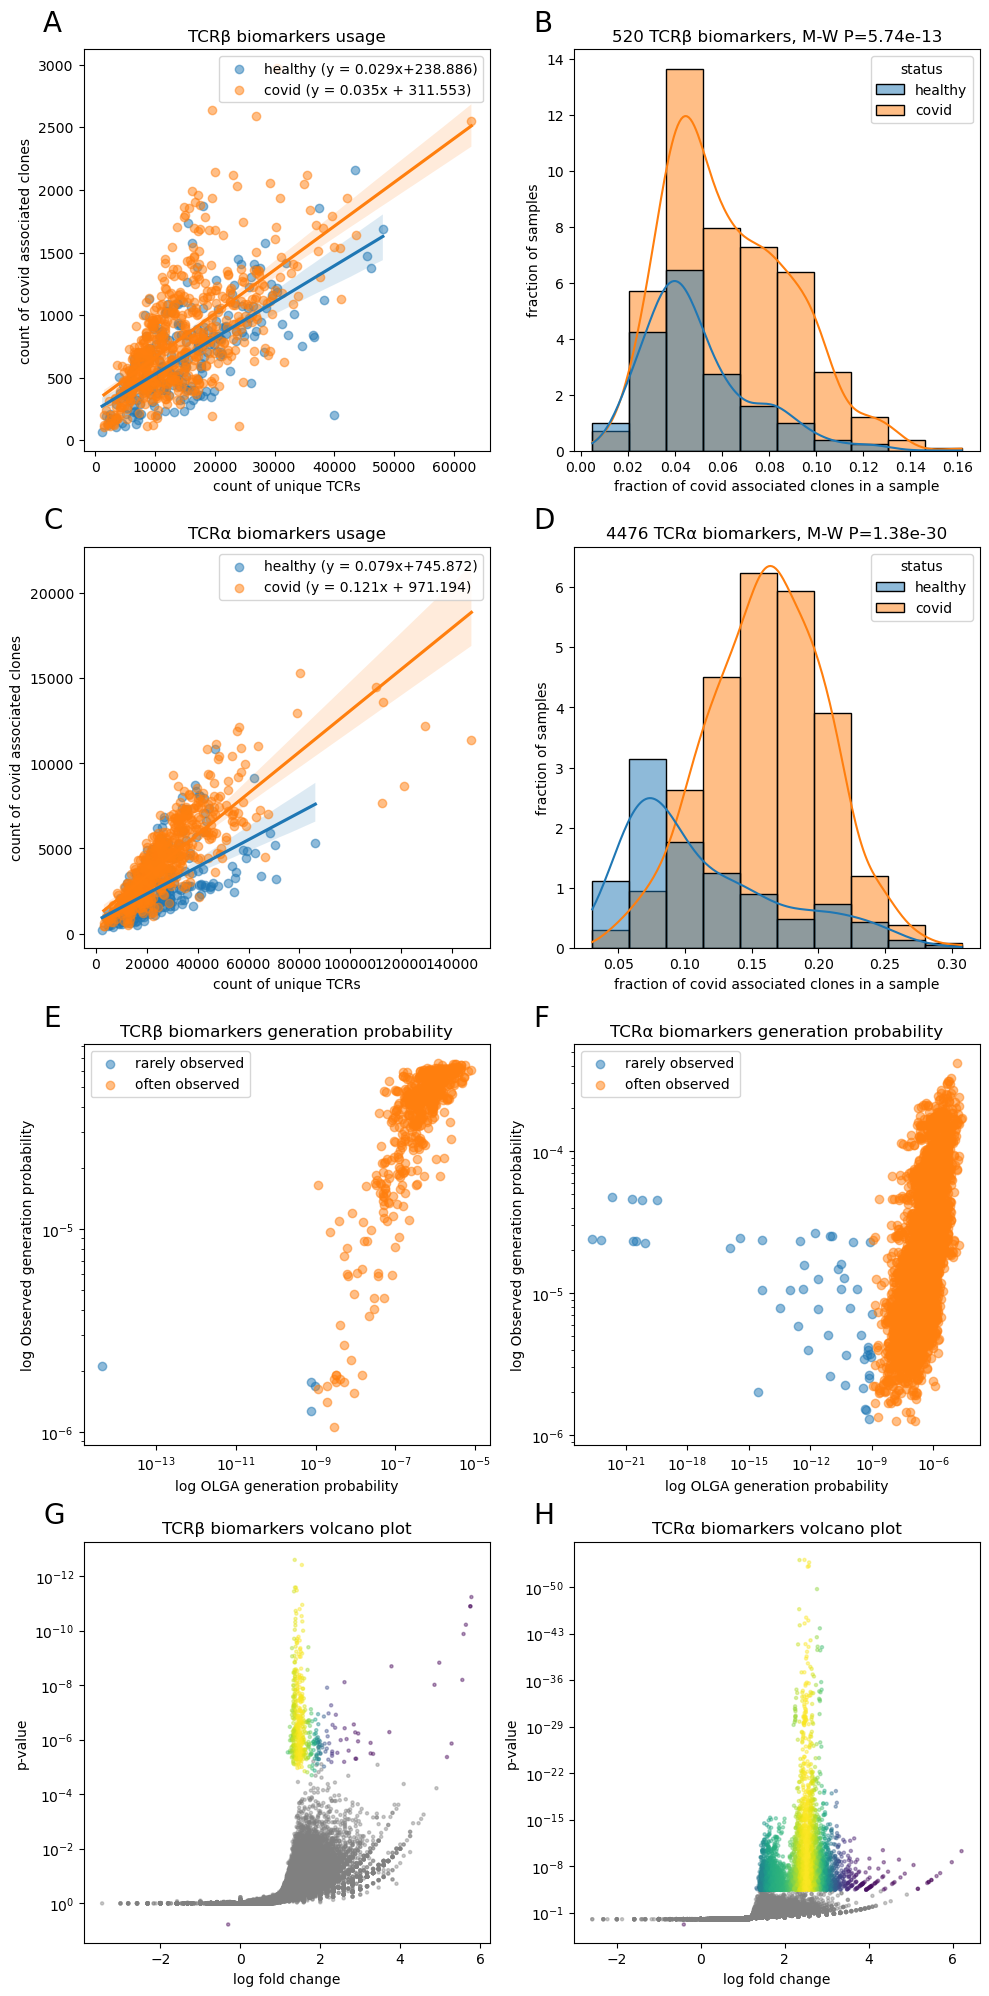

In [36]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import numpy as np

fig = plt.figure(figsize=(10, 20))
gs = GridSpec(nrows=4, 
              ncols=2)
font_size=20
delta_x=-0.1
delta_y=1.1

ax0 = fig.add_subplot(gs[0, 0])
ax1 = fig.add_subplot(gs[0, 1])
significant_clones_distribution(significant_clonotype_matrix=raw_beta_cm[raw_beta_cm.run.isin(train_runs)], 
                                run_to_number_of_clones=pd.read_csv('data/run_to_number_of_clones_fmba_TRB.csv'), 
                                desc=desc, 
                                data_description='TCRβ biomarkers',
                                by='covid',
                                reg_ax=ax0, 
                                hist_ax=ax1)
ax0.set_title('TCRβ biomarkers usage')
ax0.legend()
ax0.text(delta_x, delta_y, 'A',
     horizontalalignment='left',
     verticalalignment='top',
    transform=ax0.transAxes,
        size=font_size)

# ax1.set_title('TCRβ biomarkers histogram')
ax1.text(delta_x, delta_y, 'B',
     horizontalalignment='left',
     verticalalignment='top',
    transform=ax1.transAxes,
        size=font_size)

ax4 = fig.add_subplot(gs[2, 0])
plot_olga_cleanup_data(probas_beta, observed_threshold=1e-6, gen_threshold=1e-9, ax=ax4)
ax4.set_title('TCRβ biomarkers generation probability')
ax4.legend()
ax4.text(delta_x, delta_y, 'E',
     horizontalalignment='left',
     verticalalignment='top',
    transform=ax4.transAxes,
        size=font_size)

####################################################

ax2 = fig.add_subplot(gs[1, 0])
ax3 = fig.add_subplot(gs[1, 1])
significant_clones_distribution(significant_clonotype_matrix=raw_alpha_cm[raw_alpha_cm.run.isin(train_runs)], 
                                run_to_number_of_clones=pd.read_csv('data/run_to_number_of_clones_fmba_TRA.csv'), 
                                desc=desc, 
                                data_description='TCRα biomarkers',
                                by='covid',
                                reg_ax=ax2, 
                                hist_ax=ax3)
ax2.set_title('TCRα biomarkers usage')
ax2.legend()
ax2.text(delta_x, delta_y, 'C',
     horizontalalignment='left',
     verticalalignment='top',
    transform=ax2.transAxes,
        size=font_size)

# ax3.set_title('α biomarkers histogram')
ax3.text(delta_x, delta_y, 'D',
     horizontalalignment='left',
     verticalalignment='top',
    transform=ax3.transAxes,
        size=font_size)


ax5 = fig.add_subplot(gs[2, 1])
plot_olga_cleanup_data(probas_alpha, observed_threshold=1e-6, gen_threshold=1e-9, ax=ax5)
ax5.set_title('TCRα biomarkers generation probability')
ax5.legend()
ax5.text(delta_x, delta_y, 'F',
     horizontalalignment='left',
     verticalalignment='top',
    transform=ax5.transAxes,
        size=font_size)

###################################################
ax6 = fig.add_subplot(gs[3, 1])

plot_volcano(fold_change_data_alpha, selected_clones=clean_alpha_cm.columns, ax=ax6)
ax6.set_title('TCRα biomarkers volcano plot')
ax6.text(delta_x, delta_y, 'H',
     horizontalalignment='left',
     verticalalignment='top',
    transform=ax6.transAxes,
        size=font_size)

###################################################
ax7 = fig.add_subplot(gs[3, 0])

plot_volcano(fold_change_data_beta, selected_clones=clean_beta_cm.columns, ax=ax7)
ax7.set_title('TCRβ biomarkers volcano plot')
ax7.text(delta_x, delta_y, 'G',
     horizontalalignment='left',
     verticalalignment='top',
    transform=ax7.transAxes,
        size=font_size)

###################################################

plt.tight_layout()
plt.savefig("figures/supp_fig1.svg")
plt.savefig("figures/supp_fig1.pdf")
plt.savefig("figures/supp_fig1.png")
plt.show()

# Making up summary table for selected clones

In [37]:
def get_most_frequent_cluster_by_vdjdb_occurence(vdjdb, cluster_epitopes, gene='TRB'):
    cluster_epitopes['cluster_epitopes_freq'] = cluster_epitopes.apply(lambda x: x['count'] / vdjdb[
        (vdjdb.gene == gene) & (vdjdb['antigen.epitope'] == x['antigen.epitope'])].cdr3.nunique(), axis=1)
    cluster_epitopes = cluster_epitopes.merge(vdjdb[['antigen.epitope', 'mhc.a']])
    return cluster_epitopes.sort_values(by='cluster_epitopes_freq', ascending=False).reset_index(drop=True).loc[0, :]

def get_most_probable_antigen(x, cluster_to_epi):
    if cluster_to_epi[x] is None or len(cluster_to_epi[x]) == 0:
        return '-', '-', 0, '-'
    df = cluster_to_epi[x]
    df = df[~df['antigen.species'].str.contains('apiens')]
    if len(df) == 0:
        return '-', '-', 0, '-'
    res = get_most_frequent_cluster_by_vdjdb_occurence(
        vdjdb, 
        df,
        gene='TRB')
    return res[['antigen.epitope', 'antigen.species', 'count', 'mhc.a']]


def create_summary_stats_table(clustering_res, cluster_to_epi, cm, vdjdb, desc, gene='TRB'):
    summary = clustering_res[['cluster', 'cluster_size']].drop_duplicates()
    summary['antigen.epitope'] = summary.cluster.apply(lambda x:  get_most_probable_antigen(x, cluster_to_epi)[0])
    summary['antigen.species'] = summary.cluster.apply(lambda x:  get_most_probable_antigen(x, cluster_to_epi)[1])
    summary['num_epi_associated_clones'] = summary.cluster.apply(lambda x: get_most_probable_antigen(x, cluster_to_epi)[2])
    summary['mhc_a'] = summary.cluster.apply(lambda x: get_most_probable_antigen(x, cluster_to_epi)[3])
    summary['mhc_a'] = summary['mhc_a'].apply(lambda x: x.split(':')[0].split('-')[1])
    summary['fraction_epi_associated_clones'] = summary['num_epi_associated_clones'] / summary['cluster_size']

    train_runs = desc[~desc.is_test_run].run
    test_runs = desc[desc.is_test_run].run

    healthy_train_cm = cm[cm.run.isin(train_runs)].merge(desc[['run']][desc.COVID_status == 'healthy'])
    healthy_test_cm = cm[cm.run.isin(test_runs)].merge(desc[['run']][desc.COVID_status == 'healthy'])
    covid_train_cm = cm[cm.run.isin(train_runs)].merge(desc[['run']][desc.COVID_status != 'healthy'])
    covid_test_cm = cm[cm.run.isin(test_runs)].merge(desc[['run']][desc.COVID_status != 'healthy'])

    train_cm = cm[cm.run.isin(train_runs)]
    test_cm = cm[cm.run.isin(test_runs)]
    summary['num_samples_with_cluster_train'] = summary.cluster.apply(
        lambda x: (train_cm[clustering_res[clustering_res.cluster == x].cdr3].sum(axis=1) > 0).sum())
    summary['num_samples_with_cluster_train_healthy'] = summary.cluster.apply(
        lambda x: (healthy_train_cm[clustering_res[clustering_res.cluster == x].cdr3].sum(axis=1) > 0).sum())
    summary['num_samples_with_cluster_train_covid'] = summary.cluster.apply(
        lambda x: (covid_train_cm[clustering_res[clustering_res.cluster == x].cdr3].sum(axis=1) > 0).sum())

    summary['num_samples_with_cluster_test'] = summary.cluster.apply(
        lambda x: (test_cm[clustering_res[clustering_res.cluster == x].cdr3].sum(axis=1) > 0).sum())
    summary['num_samples_with_cluster_test_healthy'] = summary.cluster.apply(
        lambda x: (healthy_test_cm[clustering_res[clustering_res.cluster == x].cdr3].sum(axis=1) > 0).sum())
    summary['num_samples_with_cluster_test_covid'] = summary.cluster.apply(
        lambda x: (covid_test_cm[clustering_res[clustering_res.cluster == x].cdr3].sum(axis=1) > 0).sum())
    
    summary['fraction_samples_with_cluster_train'] = summary['num_samples_with_cluster_train'] / len(train_cm)
    summary['fraction_of_healthy_samples_in_cluster_train'] = summary['num_samples_with_cluster_train_healthy'] / summary['num_samples_with_cluster_train']
    summary['fraction_of_covid_samples_in_cluster_train'] = summary['num_samples_with_cluster_train_covid'] / summary['num_samples_with_cluster_train']
    
    summary['fraction_samples_with_cluster_test'] = summary['num_samples_with_cluster_test'] / len(test_cm)
    summary['fraction_of_healthy_samples_in_cluster_test'] = summary['num_samples_with_cluster_test_healthy'] / summary['num_samples_with_cluster_test']
    summary['fraction_of_covid_samples_in_cluster_test'] = summary['num_samples_with_cluster_test_covid'] / summary['num_samples_with_cluster_test']
    
    # summary.to_excel(f'figures/clustering_summary_{gene}.xlsx')
    summary.to_csv(f'figures/clustering_summary_{gene}.csv', index=False)
    return summary

In [38]:
beta_summary = create_summary_stats_table(res_beta, beta_cluster_to_epi, clean_beta_cm, vdjdb, desc=desc, gene='TRB')
beta_summary

,cluster,cluster_size,antigen.epitope,antigen.species,num_epi_associated_clones,mhc_a,fraction_epi_associated_clones,num_samples_with_cluster_train,num_samples_with_cluster_train_healthy,num_samples_with_cluster_train_covid,num_samples_with_cluster_test,num_samples_with_cluster_test_healthy,num_samples_with_cluster_test_covid,fraction_samples_with_cluster_train,fraction_of_healthy_samples_in_cluster_train,fraction_of_covid_samples_in_cluster_train,fraction_samples_with_cluster_test,fraction_of_healthy_samples_in_cluster_test,fraction_of_covid_samples_in_cluster_test
0,0,169,VTWFHAIHV,SARS-CoV-2,4,A*02,0.023669,840,232,608,116,63,53,1.000000,0.276190,0.723810,1.000000,0.543103,0.456897
169,1,122,TMADLVYAL,SARS-CoV-2,16,A*02,0.131148,840,232,608,116,63,53,1.000000,0.276190,0.723810,1.000000,0.543103,0.456897
291,2,11,LTDEMIAQY,SARS-CoV-2,11,A*01,1.000000,837,231,606,116,63,53,0.996429,0.275986,0.724014,1.000000,0.543103,0.456897
302,3,1,-,-,0,,0.000000,141,17,124,12,6,6,0.167857,0.120567,0.879433,0.103448,0.500000,0.500000
303,4,1,-,-,0,,0.000000,115,19,96,14,4,10,0.136905,0.165217,0.834783,0.120690,0.285714,0.714286
304,5,1,-,-,0,,0.000000,293,64,229,23,14,9,0.348810,0.218430,0.781570,0.198276,0.608696,0.391304
305,6,83,ALNTPKDHI,SARS-CoV-2,12,A*02,0.144578,839,231,608,116,63,53,0.998810,0.275328,0.724672,1.000000,0.543103,0.456897
388,7,1,-,-,0,,0.000000,382,94,288,51,25,26,0.454762,0.246073,0.753927,0.439655,0.490196,0.509804
389,8,42,VTDVTQLYL,SARS-CoV-2,10,A*01,0.238095,838,231,607,116,63,53,0.997619,0.275656,0.724344,1.000000,0.543103,0.456897
431,9,3,-,-,0,,0.000000,537,132,405,81,39,42,0.639286,0.245810,0.754190,0.698276,0.481481,0.518519


In [39]:
alpha_summary = create_summary_stats_table(res_alpha, alpha_cluster_to_epi, clean_alpha_cm, vdjdb, desc=desc, gene='TRA')
alpha_summary

,cluster,cluster_size,antigen.epitope,antigen.species,num_epi_associated_clones,mhc_a,fraction_epi_associated_clones,num_samples_with_cluster_train,num_samples_with_cluster_train_healthy,num_samples_with_cluster_train_covid,num_samples_with_cluster_test,num_samples_with_cluster_test_healthy,num_samples_with_cluster_test_covid,fraction_samples_with_cluster_train,fraction_of_healthy_samples_in_cluster_train,fraction_of_covid_samples_in_cluster_train,fraction_samples_with_cluster_test,fraction_of_healthy_samples_in_cluster_test,fraction_of_covid_samples_in_cluster_test
0,0,792,MFLARGIVF,SARS-CoV-2,27,A*24,0.034091,321,56,265,8,4,4,0.382143,0.174455,0.825545,0.068966,0.500000,0.500000
792,1,92,LPRWYFYYL,HCoV-HKU1,32,B*07,0.347826,384,83,301,21,11,10,0.457143,0.216146,0.783854,0.181034,0.523810,0.476190
884,2,9,-,-,0,,0.000000,417,82,335,56,28,28,0.496429,0.196643,0.803357,0.482759,0.500000,0.500000
893,3,1075,KPLPEVKIL,SARS-CoV-2,15,B*07,0.013953,322,61,261,8,4,4,0.383333,0.189441,0.810559,0.068966,0.500000,0.500000
1968,4,381,LMIERFVSL,SARS-CoV-2,20,A*02,0.052493,325,56,269,11,6,5,0.386905,0.172308,0.827692,0.094828,0.545455,0.454545
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4065,131,1,-,-,0,,0.000000,72,6,66,8,4,4,0.085714,0.083333,0.916667,0.068966,0.500000,0.500000
4066,132,9,-,-,0,,0.000000,347,78,269,45,24,21,0.413095,0.224784,0.775216,0.387931,0.533333,0.466667
4075,133,1,-,-,0,,0.000000,63,6,57,2,0,2,0.075000,0.095238,0.904762,0.017241,0.000000,1.000000
4076,134,2,-,-,0,,0.000000,214,34,180,25,11,14,0.254762,0.158879,0.841121,0.215517,0.440000,0.560000


In [40]:
beta_summary[beta_summary['antigen.epitope'] != '-']

,cluster,cluster_size,antigen.epitope,antigen.species,num_epi_associated_clones,mhc_a,fraction_epi_associated_clones,num_samples_with_cluster_train,num_samples_with_cluster_train_healthy,num_samples_with_cluster_train_covid,num_samples_with_cluster_test,num_samples_with_cluster_test_healthy,num_samples_with_cluster_test_covid,fraction_samples_with_cluster_train,fraction_of_healthy_samples_in_cluster_train,fraction_of_covid_samples_in_cluster_train,fraction_samples_with_cluster_test,fraction_of_healthy_samples_in_cluster_test,fraction_of_covid_samples_in_cluster_test
0,0,169,VTWFHAIHV,SARS-CoV-2,4,A*02,0.023669,840,232,608,116,63,53,1.000000,0.276190,0.723810,1.000000,0.543103,0.456897
169,1,122,TMADLVYAL,SARS-CoV-2,16,A*02,0.131148,840,232,608,116,63,53,1.000000,0.276190,0.723810,1.000000,0.543103,0.456897
291,2,11,LTDEMIAQY,SARS-CoV-2,11,A*01,1.000000,837,231,606,116,63,53,0.996429,0.275986,0.724014,1.000000,0.543103,0.456897
305,6,83,ALNTPKDHI,SARS-CoV-2,12,A*02,0.144578,839,231,608,116,63,53,0.998810,0.275328,0.724672,1.000000,0.543103,0.456897
389,8,42,VTDVTQLYL,SARS-CoV-2,10,A*01,0.238095,838,231,607,116,63,53,0.997619,0.275656,0.724344,1.000000,0.543103,0.456897
454,23,1,RLNEVAKNL,SARS-CoV-2,1,A*02,1.000000,141,23,118,14,8,6,0.167857,0.163121,0.836879,0.120690,0.571429,0.428571
455,24,1,FLGIITTVA,SARS-CoV-2,1,A*02,1.000000,144,23,121,11,7,4,0.171429,0.159722,0.840278,0.094828,0.636364,0.363636
456,25,2,NVLTLVYKV,SARS-CoV-2,2,A*02,1.000000,790,216,574,109,59,50,0.940476,0.273418,0.726582,0.939655,0.541284,0.458716


In [41]:
alpha_summary[alpha_summary['antigen.epitope'] != '-']

,cluster,cluster_size,antigen.epitope,antigen.species,num_epi_associated_clones,mhc_a,fraction_epi_associated_clones,num_samples_with_cluster_train,num_samples_with_cluster_train_healthy,num_samples_with_cluster_train_covid,num_samples_with_cluster_test,num_samples_with_cluster_test_healthy,num_samples_with_cluster_test_covid,fraction_samples_with_cluster_train,fraction_of_healthy_samples_in_cluster_train,fraction_of_covid_samples_in_cluster_train,fraction_samples_with_cluster_test,fraction_of_healthy_samples_in_cluster_test,fraction_of_covid_samples_in_cluster_test
0,0,792,MFLARGIVF,SARS-CoV-2,27,A*24,0.034091,321,56,265,8,4,4,0.382143,0.174455,0.825545,0.068966,0.500000,0.500000
792,1,92,LPRWYFYYL,HCoV-HKU1,32,B*07,0.347826,384,83,301,21,11,10,0.457143,0.216146,0.783854,0.181034,0.523810,0.476190
893,3,1075,KPLPEVKIL,SARS-CoV-2,15,B*07,0.013953,322,61,261,8,4,4,0.383333,0.189441,0.810559,0.068966,0.500000,0.500000
1968,4,381,LMIERFVSL,SARS-CoV-2,20,A*02,0.052493,325,56,269,11,6,5,0.386905,0.172308,0.827692,0.094828,0.545455,0.454545
2349,5,316,QVPLRPMTYK,HIV-1,13,A*03,0.041139,832,229,603,116,63,53,0.990476,0.275240,0.724760,1.000000,0.543103,0.456897
2665,6,80,YVYSRVKNL,SARS-CoV-2,21,A*02,0.262500,840,232,608,116,63,53,1.000000,0.276190,0.723810,1.000000,0.543103,0.456897
2922,11,157,APFSEQEQPVLG,TriticumAestivum,21,DQA1*02,0.133758,830,230,600,115,62,53,0.988095,0.277108,0.722892,0.991379,0.539130,0.460870
3081,13,9,FKDNVILLN,SARS-CoV-2,6,A*02,0.666667,834,229,605,115,62,53,0.992857,0.274580,0.725420,0.991379,0.539130,0.460870
3091,15,231,YINVFAFPF,SARS-CoV-2,13,A*24,0.056277,297,54,243,3,1,2,0.353571,0.181818,0.818182,0.025862,0.333333,0.666667
3331,22,42,FLLNKEMYL,SARS-CoV-2,11,A*02,0.261905,767,203,564,106,55,51,0.913095,0.264668,0.735332,0.913793,0.518868,0.481132
